# Setup; importing and ginga stuff

In [1]:
%matplotlib notebook

import matplotlib.pyplot as plt

#import statements
import vis_calculations as viscalc
import vis_plotting as visplot
import vis_coordinates as viscoords

import numpy as np
from importlib import reload  #for debugging purposes


In [2]:
#ginga setup stuff

from ginga.version import version
version
from ginga.web.pgw import ipg
# Set this to True if you have a non-buggy python OpenCv bindings--it greatly speeds up some operations
use_opencv = True
server = ipg.make_server(host='localhost', port=9914, use_opencv=use_opencv)
server.start(no_ioloop=True)

#create a viewer window and open
v1 = server.get_viewer('v1')
v1.open()

# Connect to Database


In [ ]:

###??? to Check - can I access this file.

try:
    file = open("/Users/chyan/Documents/workspace/ics_mcsActor/etc/dbpasswd.cfg", "r")
    passstring = file.read()
    print('text="Password reading OK. value = %s."'%(passstring))
except:
    print('text="could not get db password"')

try:
    conn = psycopg2.connect("dbname='fps' user='pfs' host='133.40.164.208' password="+passstring)
    print('text="Connected to FPS database."')
except:
    print('text="I am unable to connect to the database."')
    
    

# Read centroids and image from database

In [ ]:

#set moveID and frameID as needed. 

frameId = 209
moveId = 1
cmd_string = f"""select * from mcsEngTable where frameId={frameId} and moveId={moveId}"""

#code from Chi-Hung
data=np.array([])
n = 0
with conn.cursor() as curs:
        curs.execute(cmd_string)
        rows=curs.fetchall()
        for idx, val in enumerate(rows):
            if idx == 0: data = val 
            if idx != 0: data = np.vstack([data,val])
conn.commit()

centroids=data[:,4:11]
filename=???  ##need to sett his, and check ID numbers

# An embedded window for the image

In [3]:
#embed the viewer window
v1.embed(height=650)

#use + and - to zoom in on the region of interest. 


/Users/karr/anaconda/envs/py35/lib/python3.5/site-packages/ginga/Bindings.py:600: RuntimeWarning: divide by zero encountered in double_scalars
  xthm_pct = max(min_pct, min(abs_x / (rx2 - rx1), max_pct))
/Users/karr/anaconda/envs/py35/lib/python3.5/site-packages/ginga/Bindings.py:601: RuntimeWarning: divide by zero encountered in double_scalars
  ythm_pct = max(min_pct, min(abs_y / (ry2 - ry1), max_pct))
/Users/karr/anaconda/envs/py35/lib/python3.5/site-packages/ginga/Bindings.py:604: RuntimeWarning: divide by zero encountered in double_scalars
  pct_x = min(max(0.0, abs(0.0 - rx1) / rng_x), 1.0)
/Users/karr/anaconda/envs/py35/lib/python3.5/site-packages/ginga/Bindings.py:605: RuntimeWarning: divide by zero encountered in double_scalars
  pct_y = min(max(0.0, abs(0.0 - ry1) / rng_y), 1.0)
/Users/karr/anaconda/envs/py35/lib/python3.5/site-packages/ginga/Bindings.py:2072: RuntimeWarning: invalid value encountered in double_scalars
  amt_x = float(dx) / res.rng_x * pan_accel
/Users/karr/a

# Set Parameters

IN the following section, set the parameters used by the centroiding
algorithm, as well as the scale between image pixels and mm at the mask

In [4]:
#set parameters for centroiding

#basic parameters - threshold probably needs to be tuned it should be 
#above the background but below the lowest peak value.  Used for re-running
#stuff locally. 

fwhm=3        
boxsize=9
thresh=2500

#shape parameters for centroiding. If the points are not circular,
#rl and rh may need to be changed; -1, 1 are the values for a circular
#psf. sl and sh should probably not need to be changed

rl=-2.5
rh=1.3
sl=0.05
sh=0.5

#scale for the instrument setup (no longer used, kept for reference)
inst_scale=5006./340

#rotation of the mask wrt the image (no longer used, kept for reference)

rotated=1

#prefix is for output plots, filename is the input plot
prefix="test"

#inter=1 displays to screen and file, inter=0 for script work. 
inter=1


# filename for image on disk

In [7]:

#for testing/local purposes, run if not using the database. 
filename="MCST_010_001.fits"


# Load the image

The following section loads the image into the ginga plugin, and 
into an image array. 


In [8]:
#load a file into viewer (replace with database stuff)
v1.load(filename)

#read the image from file from file
image=visplot.getImage(filename)



# Get Region of Interest

For the first night, we won't know the position of the mask on the image. To get an approximation, pan and zoom to the appropriate region 
in the ginga viewer above, and execute the followin section to read the 
region shown.

In [11]:


## #get region panned to (needed for later analysis)

regionCoords=v1.get_pan_rect()
region=np.array([regionCoords[0,0],regionCoords[1,0],regionCoords[3,1],regionCoords[0,1]]).astype('int')

print(regionCoords)
print(region)

##estimate the threshold from the statistics


[[ -320.  7689.]
 [ 9280.  7689.]
 [ 9280. -1911.]
 [ -320. -1911.]]
[ -320  9280 -1911  7689]


# Basic Stats

Calculate some basics statistics for the selected region and plot a histogram

<IPython.core.display.Javascript object>


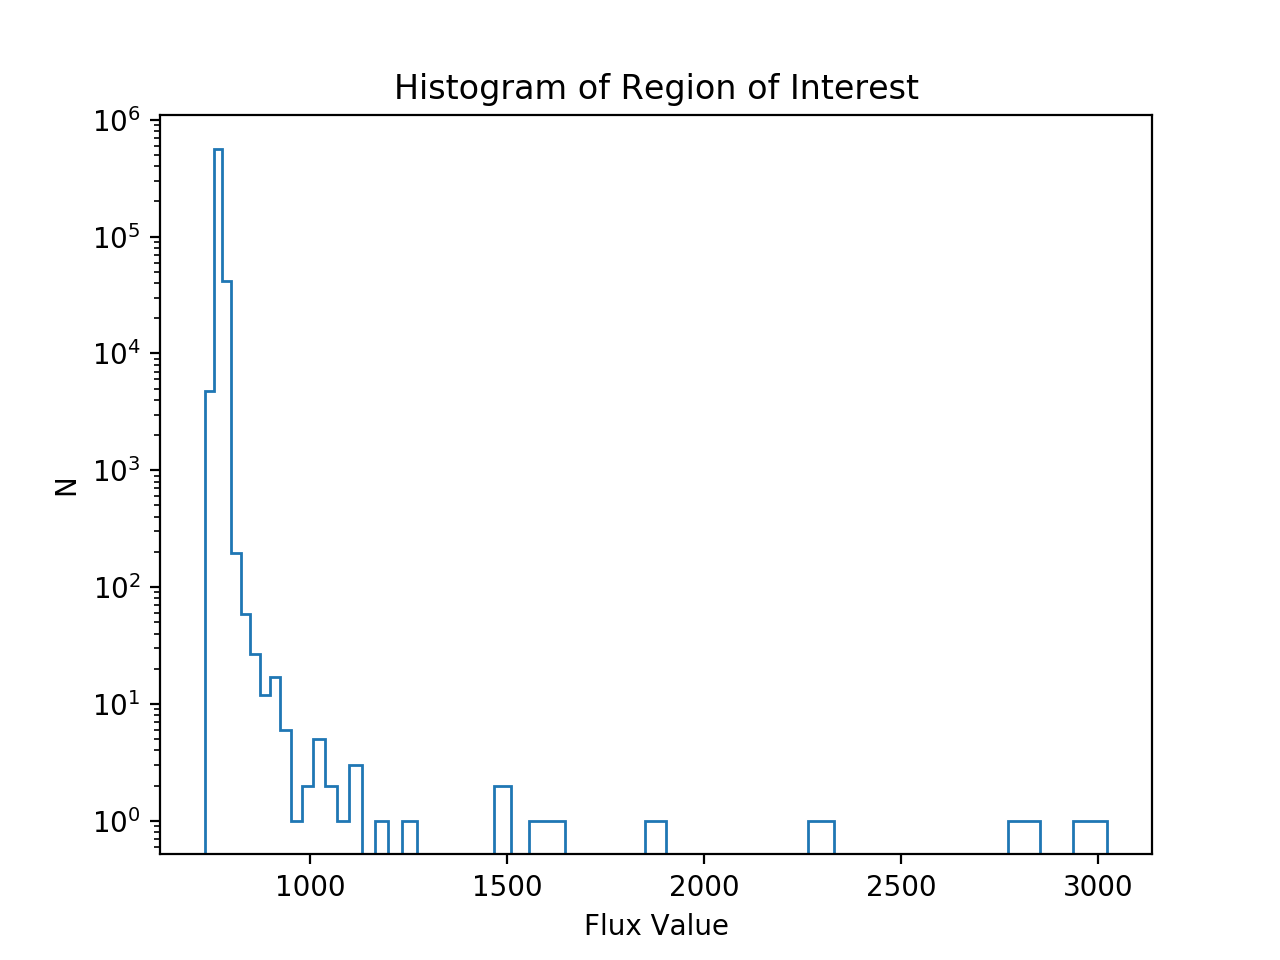

here
772.741730441 3.06718115656
72.766695523 797.430534733 (5778, 8960)
2252.76444519


In [41]:
reload(visplot)

backImage, rmsImage = visplot.plotImageStats(image[region[2]:region[3],region[0]:region[1]],prefix,inter) 
print(backImage,rmsImage)

print(image.std(),image.mean(),image.shape)

#interactive threshold (same as MHS command)
thresh=image.mean()+20*image.std()
print(thresh)


# Do the centroiding

The following section runs the centroiding algorithm, and plots the result. 

In [37]:
# 
#do the centroiding. Run this if not retrieving from MCS database. 
reload(viscalc)

#you may need to do this a couple of times, to tune parameters
#thresh=2400


x,y,fx,fy,back,peak=viscalc.getCentroids(image,fwhm,boxsize,thresh,rl,rh,sl,sh)

print(x.shape)
xx,yy=viscoords.maskinMM(1)
print(len(xx))
#x,y,fx,fy,back,peak=viscalc.getCentroids(image[region[2]:region[3],region[0]:region[1]],fwhm,boxsize,thresh,rl,rh,sl,sh)
#x=x+region[0]
#y=y+region[1]



(3576,)
3576


<IPython.core.display.Javascript object>


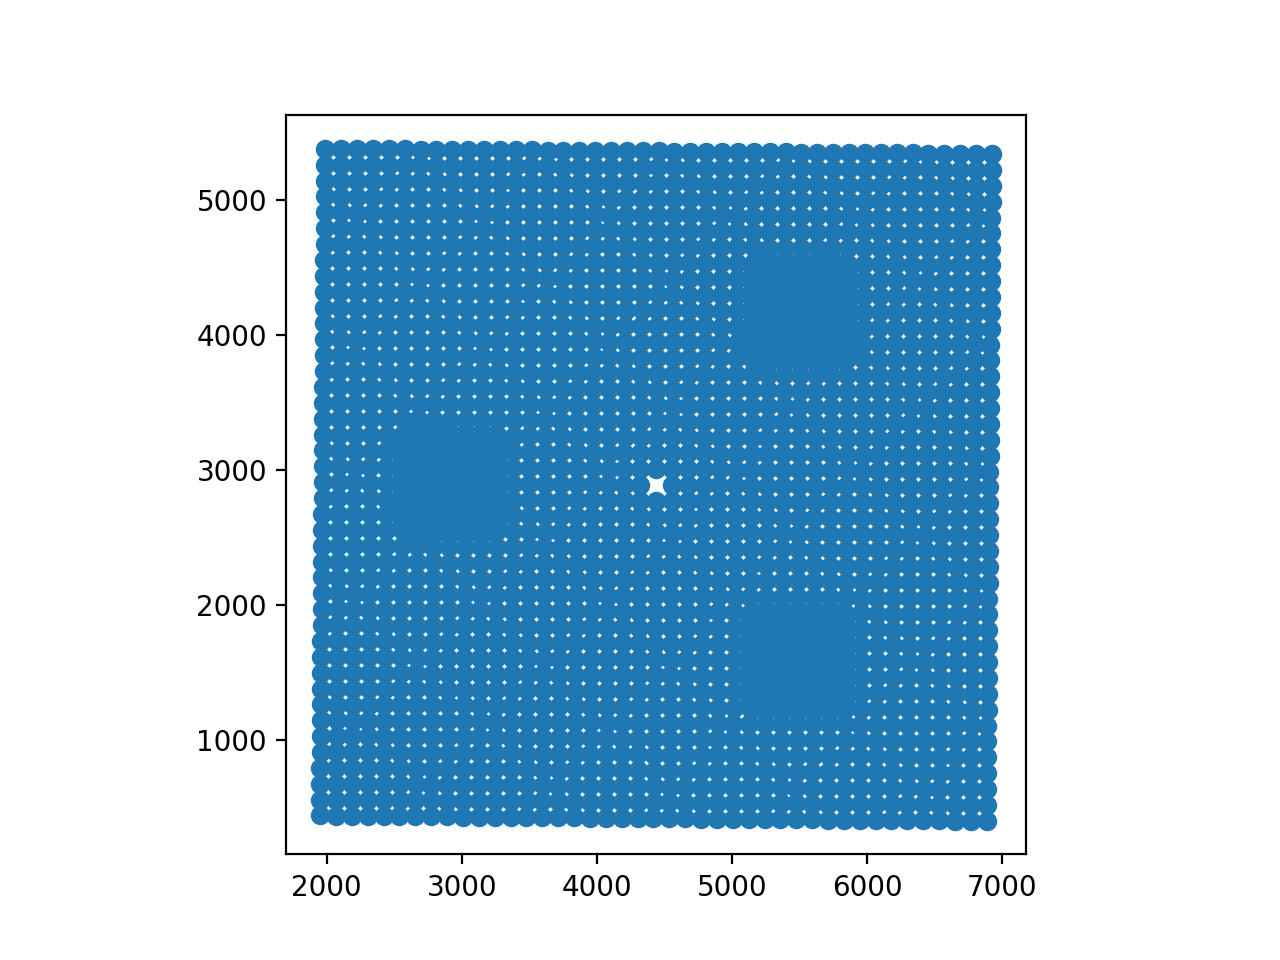

In [38]:

#plot the points for a visual check. 

visplot.checkCentroids(x,y,0,prefix,inter)


# Mask calculations


From this point on, the calculations are the same regardless of the source of the data. 

The next section calculates the approximate position of the mask region, and the angle of rotation. Change the rotated parameter if 
the mask and image are rotated 90 degrees wrt each other (this is a 
difference between data taken in Taipei and Hilo. 

It then scales the centroids to mm coordinates, and applies a rotation to the mask if needed. The image spots and mask spots are then matched.



2660.11308758 2704.26594857 1.56195933334 14.69232385


<IPython.core.display.Javascript object>


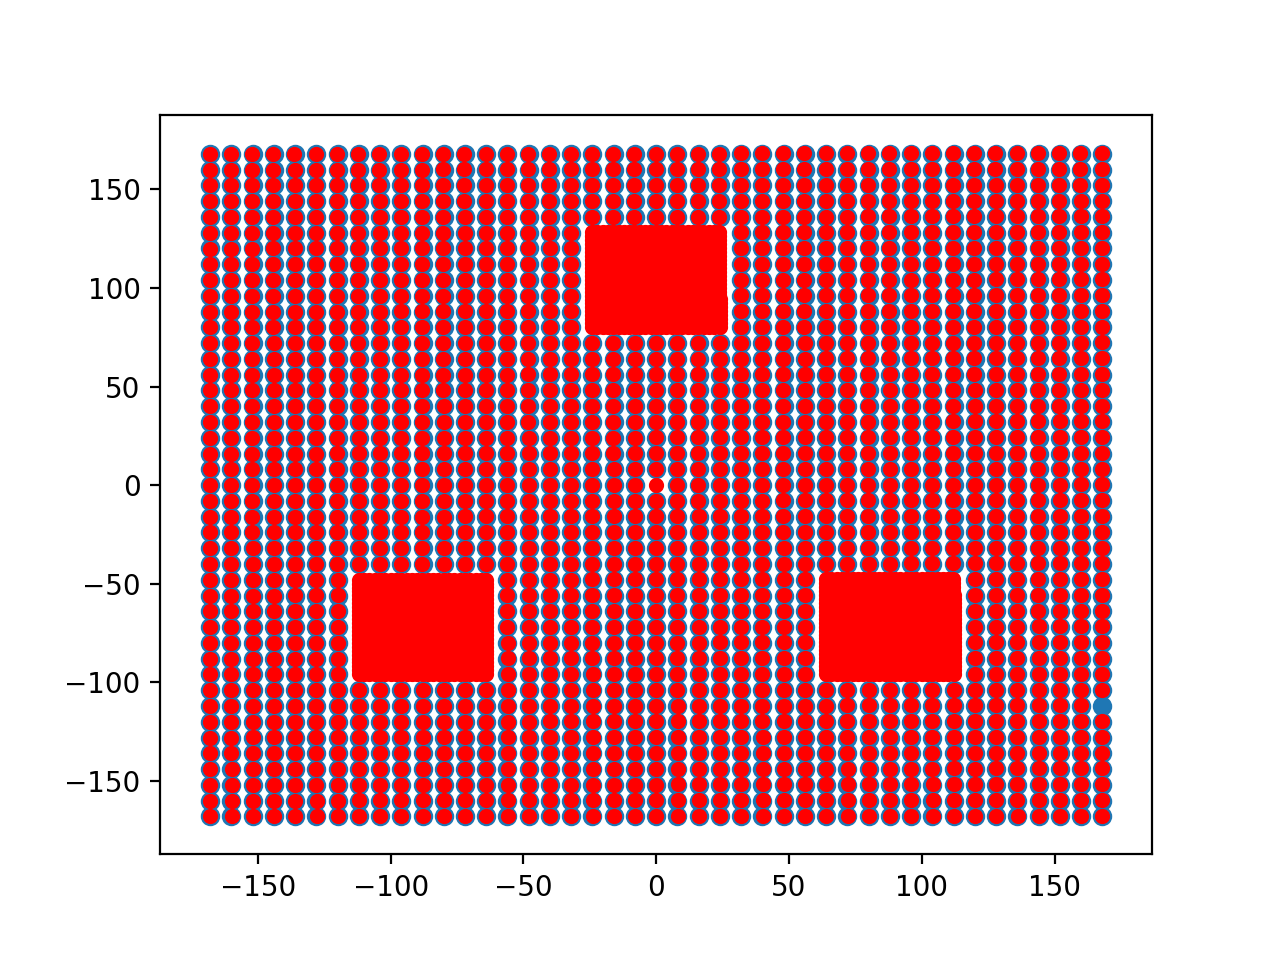

<IPython.core.display.Javascript object>


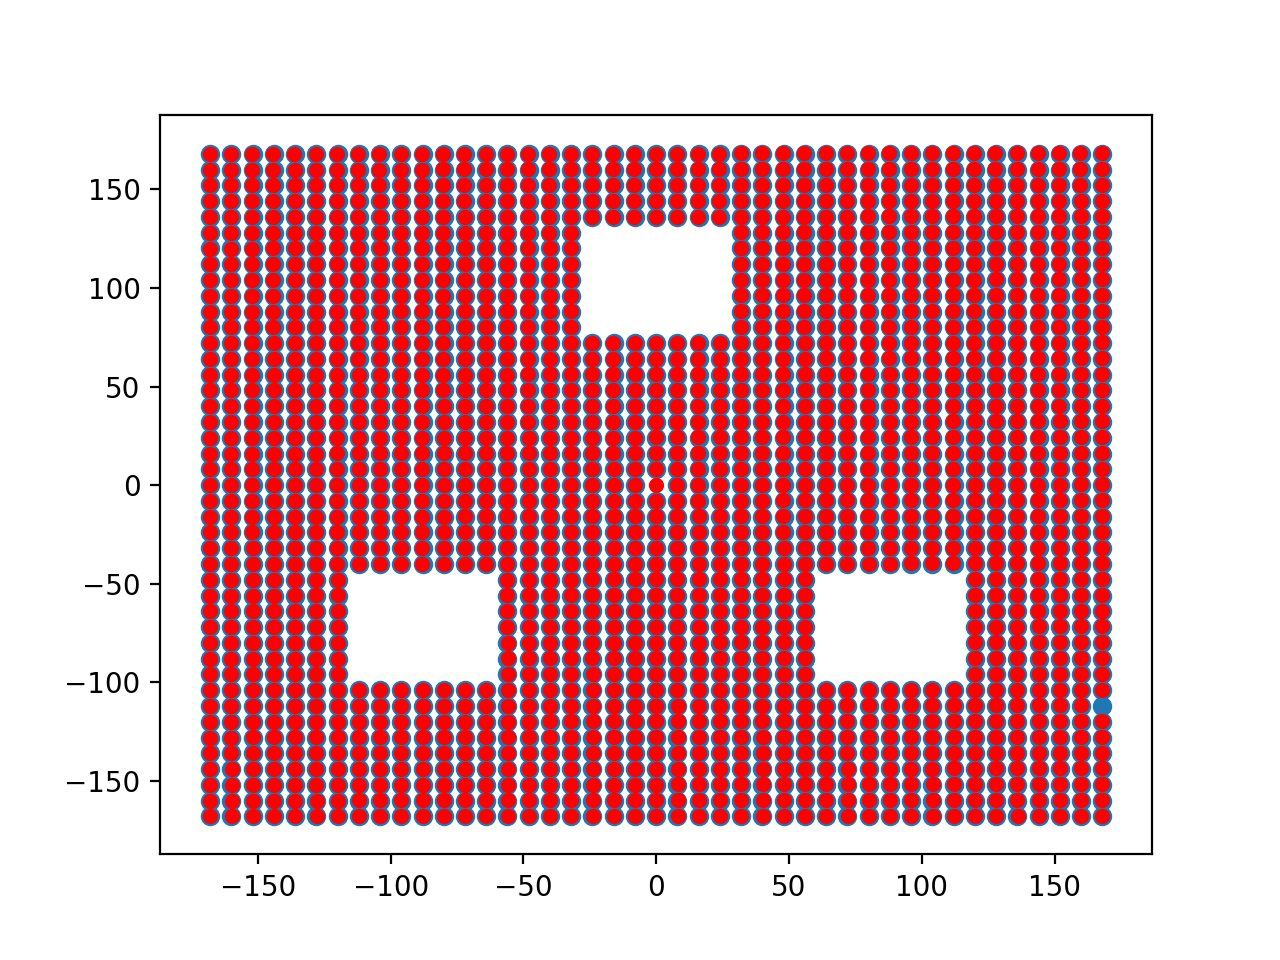

In [24]:

#get the approximate transformation

reload(viscoords)
xm,ym,xd,yd,angle,scale=viscoords.getApproximateTransform(x,y,1)
includeClose=0
print(xd,yd,angle,scale)

#get the mask coordinates and transform 
xx,yy=viscoords.maskinMM(includeClose)
xx=xx-168
yy=yy-168
xa,ya=viscoords.transformMask(x,y,-xd,-yd,0,1)
xc,yc=viscoords.transformMask(xa,ya,0,0,-angle,1/scale)
#xc,yc=viscoords.transformMask(x,y,-xd,-yd,-angle,1/scale)

#do the point registration. 
xs,ys,fxs,fys,peaks=viscoords.matchPoints(xc,yc,xx,yy,fx,fy,peak)

#plot the results to check
visplot.checkMatched(xc,yc,xx,yy,prefix,inter)
visplot.checkMatched(xs,ys,xx,yy,prefix,inter)




# Image Quality Plots

Now we get into the analysis part. 

Plots of FWHM values, peak values, and a rough calculation of total flux.  Set plotrange to the range you want for the colour bar (2 element numpy array); the default is min and max. 


(1701,) (1701,) (1701,)


<IPython.core.display.Javascript object>


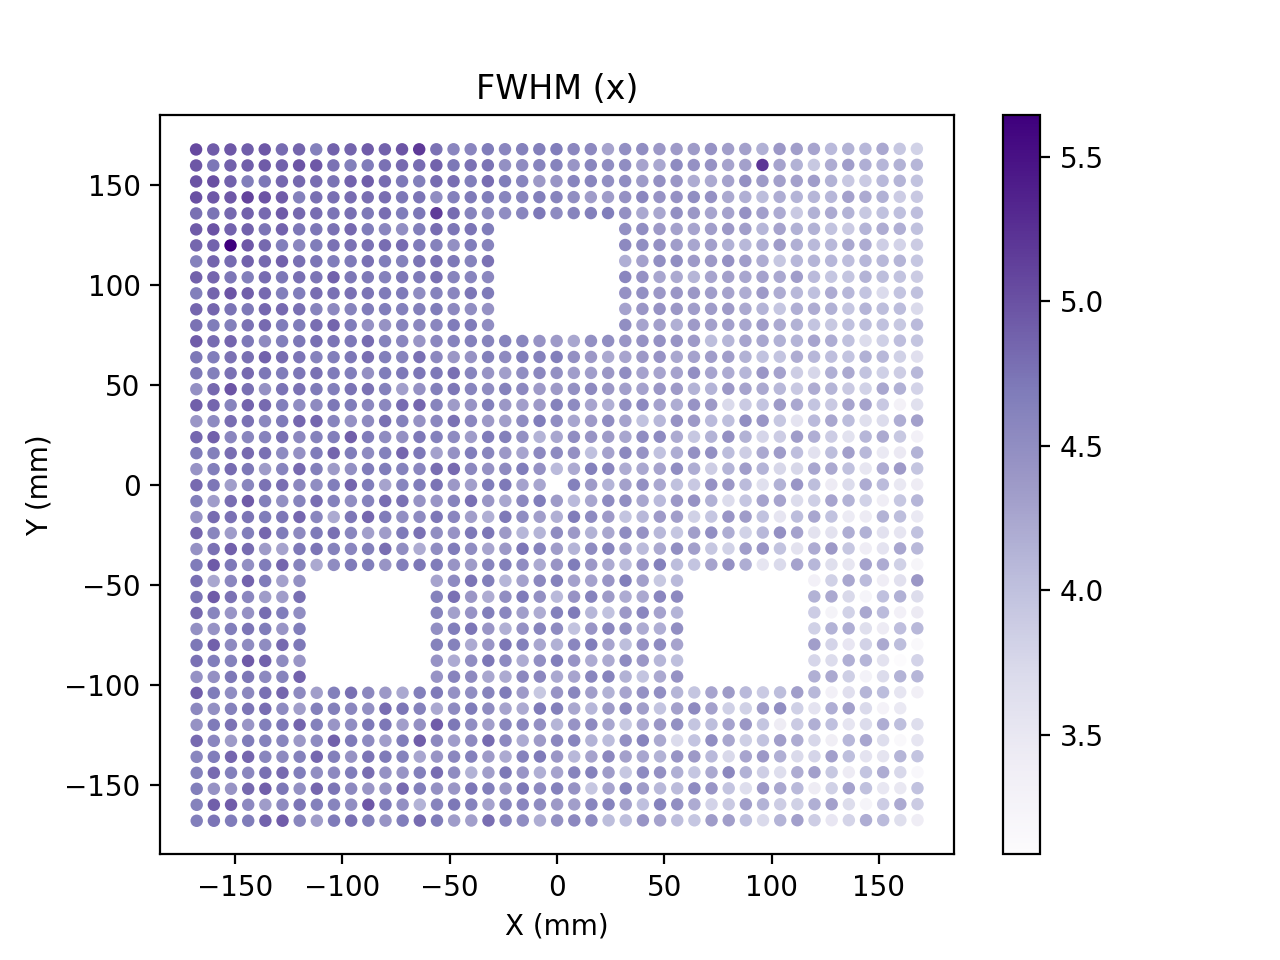

<IPython.core.display.Javascript object>


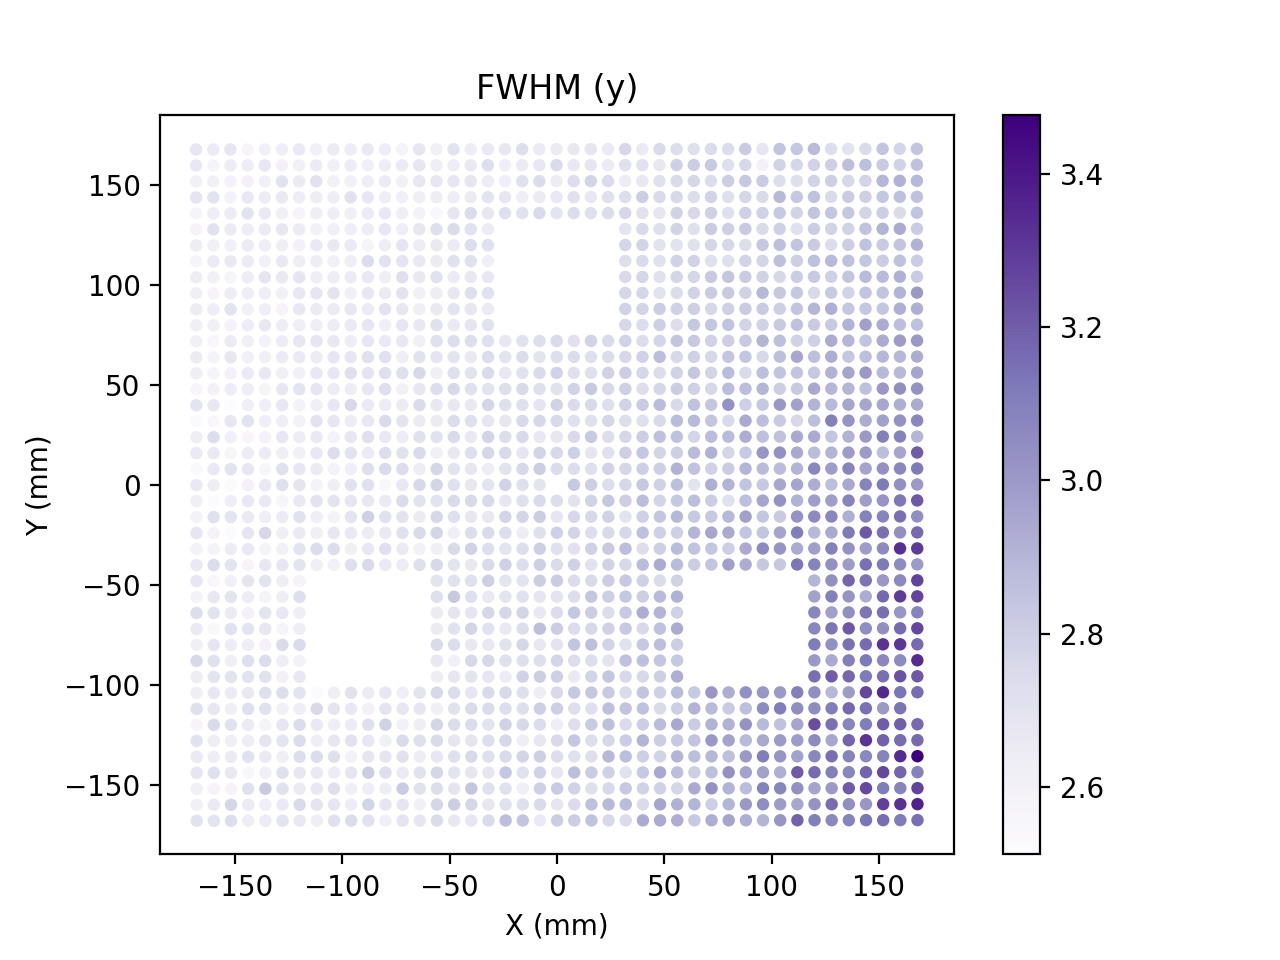

/Users/karr/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


<IPython.core.display.Javascript object>


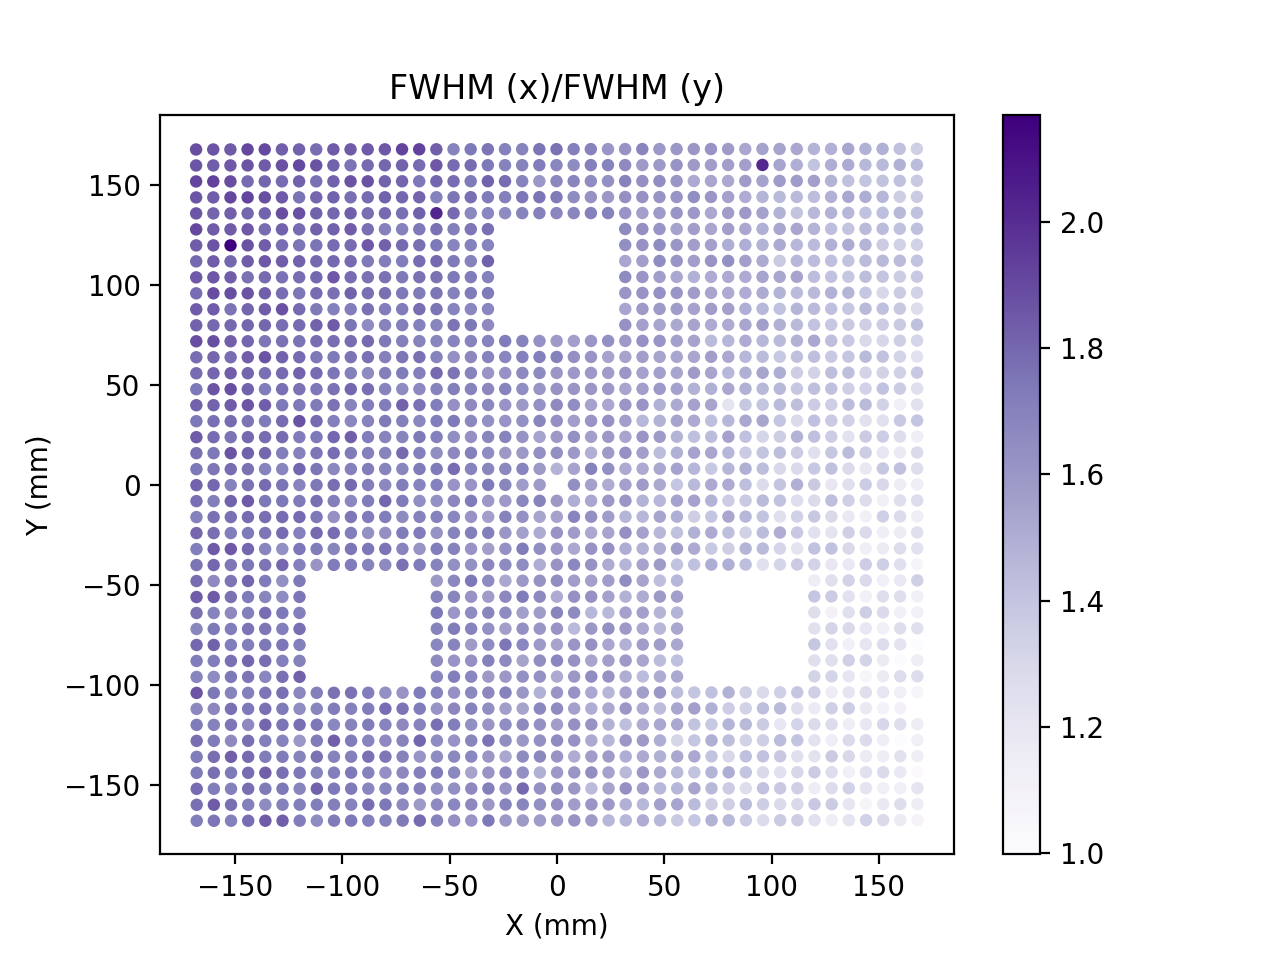

In [30]:
reload(visplot)
limit=10
plotrange=None
print(xx.shape,yy.shape,fxs.shape)
visplot.plotVal(xs,ys,fxs,limit,plotrange,"FWHM (x)",prefix,"_fwhmx",'mm',inter)
visplot.plotVal(xs,ys,fys,limit,plotrange,"FWHM (y)",prefix,"_fwhmy",'mm',inter)
visplot.plotVal(xs,ys,fxs/fys,0,plotrange,"FWHM (x)/FWHM (y)",prefix,"_fwhmxy",'mm',inter)


# Distortion Plots

Calculations and plots for distortion of a single field. The results are plotted in three forms; quiver, colour map in mm units, colour map in units of % of the field size. 


sx= 1.00014599123  sy= 1.00014599123


<IPython.core.display.Javascript object>


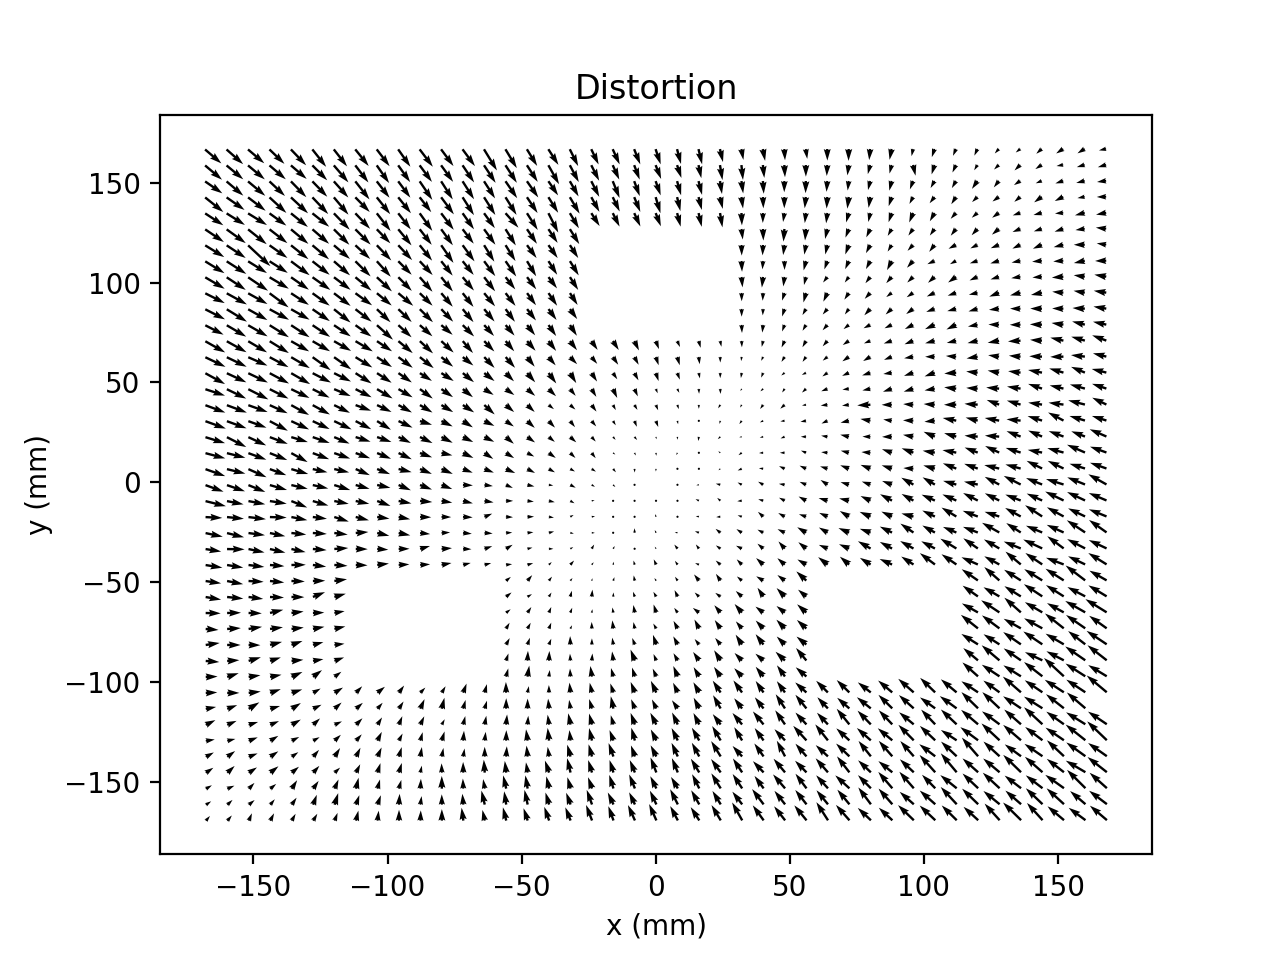

<IPython.core.display.Javascript object>


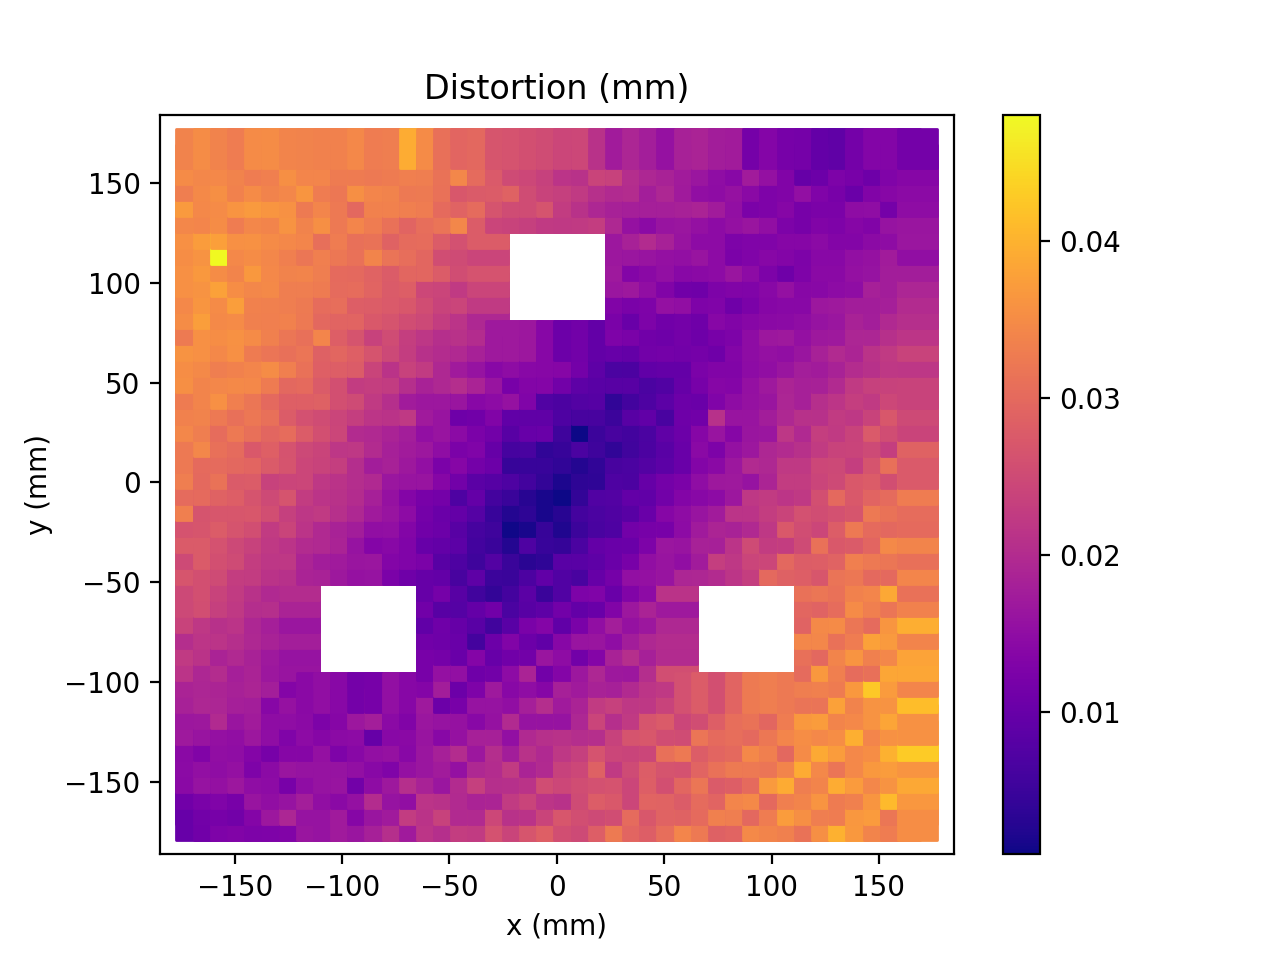

<IPython.core.display.Javascript object>


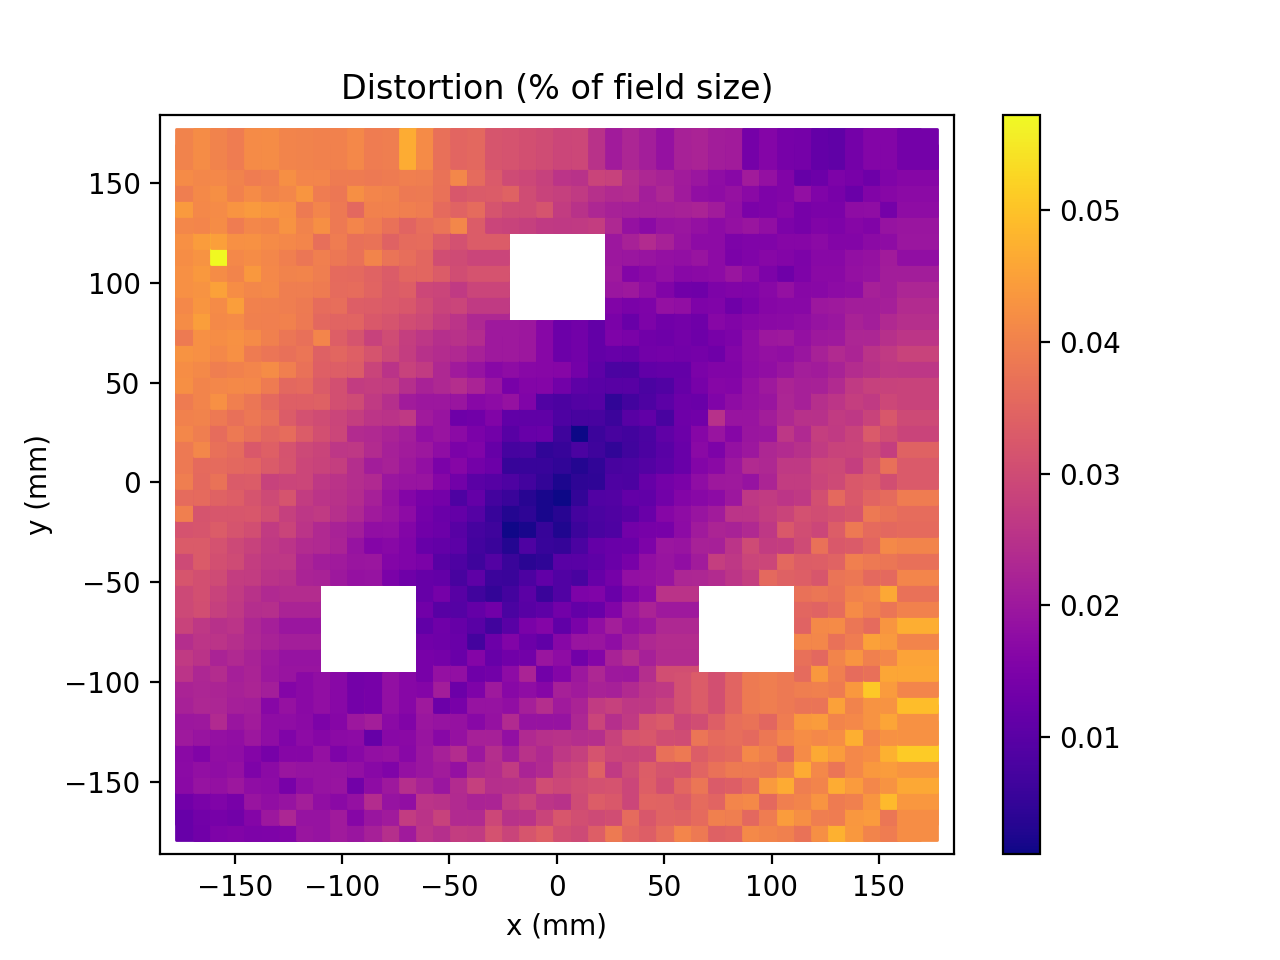

In [31]:
reload(visplot)
reload(viscalc)
c,c1,pts1,pts2,diffx,diffy=viscalc.simpleDistortion(xx,yy,xs,ys)
limit=5
visplot.plotDistortion(c,c1,pts1,pts2,diffx,diffy,fxs,fys,peaks,limit,prefix,'mm',inter)


In [57]:

cenParams=[fwhm,boxsize,thresh,rl,rh,sl,sh]
cenOut=[xs,ys,fxs,fys,peaks]
distOut=[c,c1,diffx,diffy,pts1,pts2]

visIO.imageQualitySave(prefix,filename,cenParams,cenOut,distOut)


[ 0.  0.  0. ...,  0.  0.  0.]
